In [81]:
import scipy
print(scipy.__version__)
%matplotlib inline

1.1.0


In [9]:
import cellgrid 
import numpy as np
from MDAnalysis.lib.distances import self_distance_array,distance_array
from scipy.spatial.distance import squareform
from initialization import init_uniform
from MDAnalysis.lib.pkdtree import PeriodicKDTree
import itertools

In [43]:
def bf_select(box, points, maxdist):
    distance = self_distance_array(points,box)
    distance = scipy.spatial.distance.squareform(distance)
    distance[np.tril_indices(distance.shape[0])] = (1.1*maxdist)
    mask = np.where((distance < maxdist))
    out = tuple((np.column_stack((mask[0],mask[1])),distance[mask]))
    return out
    
def cg_select(box, points, maxdist):
    indx,dist = cellgrid.capped_self_distance_array(points,maxdist,box=box)
    mask = np.where(dist<maxdist)
    return indx[mask],dist[mask]

def kdtree_distance(box,points,maxdist):
    kdtree = PeriodicKDTree(box,bucket_size=10)
    kdtree.set_coords(points)
    pair,distances = list(),list()
    for idx,centers in enumerate(points):
        kdtree.search(centers,maxdist)
        indices = kdtree.get_indices()
        indices = [i for i in indices if i > idx]
        distances += list(distance_array(centers.reshape((1,3)),points[indices],box).flatten())
        pair += list(itertools.product(([idx]),indices))    
    return tuple((np.asarray(pair),np.asarray(distances)))

In [11]:
box = np.array([100,100,100,90,90,90],dtype=np.float32)
box1, points = init_uniform(box,Npoints=1000)
maxdist = 10.0

In [54]:
#Brute Force
bf = bf_select(box,points,maxdist)
print(bf)

(array([[  0,   4],
       [  0, 177],
       [  0, 200],
       ...,
       [953, 997],
       [957, 960],
       [963, 984]]), array([9.64893475, 8.10482213, 9.1653019 , ..., 8.90244494, 3.7786522 ,
       9.05695633]))


In [55]:
#CellGrid Selection
cg = cg_select(box1,points,maxdist)
print(cg)

(array([[252, 468],
       [252, 884],
       [252,  66],
       ...,
       [490, 135],
       [490, 179],
       [490, 261]]), array([7.502872 , 9.05817  , 8.593316 , ..., 7.2601304, 5.7279763,
       9.795639 ], dtype=float32))


In [14]:
#KDTree selections
kd = kdtree_distance(box,points,maxdist)
print(kd,"type:",type(kd))

(array([[  0,   4],
       [  0, 177],
       [  0, 200],
       ...,
       [953, 997],
       [957, 960],
       [963, 984]]), array([9.64893475, 8.10482213, 9.1653019 , ..., 8.90244494, 3.7786522 ,
       9.05695633])) type: <class 'tuple'>


In [56]:
#Testing
#Number of contacts
np.testing.assert_equal(kd[1].shape,cg[1].shape) #Comparing total number of pairs with distance array
np.testing.assert_equal(bf[1].shape,cg[1].shape)

#Array Values 
np.testing.assert_array_almost_equal(np.sort(bf[1].astype(np.float64)),np.sort(cg[1]),decimal=5) #Comparing array values
np.testing.assert_almost_equal(bf[1],kd[1]) 

In [78]:
##Benchmarking - Time
Npoints = np.logspace(2,3,num=5,dtype='int32')
box = np.array([100,100,100,90,90,90],dtype=np.float32)
maxdist = 10.0

In [153]:
time_kdpair = []
for num in Npoints:
    box1, points = init_uniform(box,Npoints=num)
    kdpair = %timeit -o -n 10 kdtree_distance(box,points,maxdist)
    time_kdpair.append([kdpair.average,kdpair.stdev])

12.1 ms ± 1.44 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
22.4 ms ± 1.06 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
39 ms ± 916 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
71.4 ms ± 1.43 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
134 ms ± 1.26 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [195]:
kd_plot = np.array(time_kdpair).T
print(kd_plot[0])
kd_error = np.array([-kd_plot[1],kd_plot[1]])
print(error)

[0.01206623 0.02235613 0.0390171  0.07143534 0.13359461]
[[-0.00144469 -0.00106152 -0.00091639 -0.0014263  -0.00126105]
 [ 0.00144469  0.00106152  0.00091639  0.0014263   0.00126105]]


In [112]:
import matplotlib
import matplotlib.pyplot as plt

<ErrorbarContainer object of 3 artists>

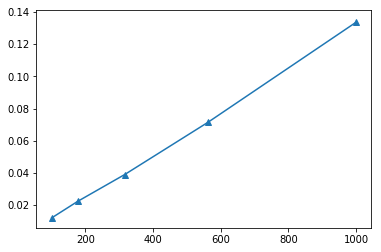

In [194]:
plt.errorbar(Npoints,var_plot[0], yerr=error, marker='^',fmt='-o')